On s'attend à ce que la regression linéaire soit plus efficace que polynomiale carré car on l'a vu dans EDA

Relation linéaire entre happiness et 3 facteurs favorisent regression linéaire mais les questions de seuil (corruption) laissent penser que random forest(highlight) va capter l'info

2 questions:
* Peut on prédire l'happiness quand on connait les facteurs d'un pays?

* Peut on prédire h'appiness uniquement avec son historique des années précédentes ?
Puisqu'on a pas de données sur 2020, on doit préduire l'happiness uniquement avec l'historique.

# Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

[Context](#Co)<br>
[Import packages and data](#0)<br>
    
1. [**Can we predict a country happiness if we know the gdp per capita, life expectancy and other factors values?**](#Fac)<br>
    [Model 1: using all factors as features](#MF1)<br>
    [Model 2: variable selection (correlation matrix, VIF and RSE)](#MF2)<br>
    
    
2. [**Can we predict a country happiness only with his historical ?**](#Hi)<br>
    [Model 1: using all historical features (from year-1 to year-3)](#MH1)<br>
    [Model 2: using happiness score historical (from year-1 to year-3](#MH2)<br>


</div>
<hr>

<a name="Co"></a>
# Context

The **World Happiness Report** is a landmark survey of the state of global happiness from 2015 to 2019 according to 6 main factors:
* economic production, 
* social support, 
* life expectancy, freedom, 
* absence of corruption, 
* and generosity

### Purposes of the project
<ins> Data analysis: </ins>
1. Give a clear picture of happiness around the world in 2019
2. Analyse trends in happiness from 2015 to 2019
    
<ins> Forecasting with Machine Learning</ins>(*)
1. How happy will countries be in 2020 ?
2. In which countries happiness will increase in 2020 ?

(\*) *Although data don't contain related information, the global pandemic may have a tremendous impact on the results*

You can find the whole presentation and information about the data in the **Project Presentation** notebook

### Workflow
* Cleaning
* EDA
* Data Visualization
* Preprocessing
* **Machine Learning**

--------
In this notebook

------------
------------
<a name="0"></a>
# Import packages and data

In [1]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

In [33]:
# import cleaned and normalized data
df = pd.read_csv('data/data_clean_norm.csv')

df.sort_values(by=["country","year"],ascending=True)

df['happiness_scoreP1'] = df.groupby('country')['happiness_score'].shift()

df.set_index("country",inplace=True)

df_dummies_reg = pd.get_dummies(df['region']).reset_index().drop_duplicates().set_index("country")
    
df = pd.merge(df, df_dummies_reg, left_index=True, right_index=True, how="inner")


df.drop(columns=["happiness_rank","region"],inplace=True)

fact_train_set = df[df['year'].isin([2018])].copy()
fact_test_set = df[df['year'].isin([2019])].copy()


# import historic datasets
hist_train_set = pd.read_csv('data/train_set.csv', index_col="country")
hist_test_set = pd.read_csv('data/test_set.csv', index_col="country")

# drop region and year
hist_train_set.drop(columns=['year','region'],inplace=True)
hist_test_set.drop(columns=['year','region'],inplace=True)

# list of factors
l_factors = ['life_expectancy', 'gdp_per_capita', 'social_support', 
             'freedom','generosity', 'corruption_perception'] 

l_happiness_histo = ['happiness_scoreP1', 'happiness_scoreP2', 'happiness_scoreP3']

-------
# About Modelisation


### Algorithms
For this notebook, we created a function that will facilitate the modelisation.
`compare algo` train, test and evaluation several regression algorithms and compare them according to Mean Squared Error (MSE) metrics. Algorithms are the following:
* A trivial model that will serve as benchmark: In our case we'll use euristic happiness_score(N) = happiness_score(N-1)
* Linear regression
* Polynomial regression (²)
* Random forest (100 models built with gris random parameters - best model is selected according to MSE on test set)

In [3]:
def train_test_metrics(y_test, y_pred_test, y_train=[], y_pred_train=[], method="", display=True):
    """
    """
    d_mse = {"test": None,"train": None}
    d_mse["test"] = mean_squared_error(y_test, y_pred_test)
    
    if display:
        print(method+" test_set mse:", d_mse["test"])
    
    if len(y_train)>0:
        d_mse["train"] = mean_squared_error(y_train, y_pred_train)
        if display:
            print(method+" train_set mse:", d_mse["train"])

    return d_mse

In [24]:
def compare_algo(df_train, df_test, target, l_features, y_test_benchmark):
    """
    Compare different Machine Learning Alrogithms for regression
    """
    X_train = df_train[l_features].copy()
    y_train = df_train[target].copy()

    X_test = df_test[l_features].copy()
    y_test = df_test[target].copy()
    
    # Benchmark
    benchmark_mse = train_test_metrics(y_test=y_test, y_pred_test=y_test_benchmark, 
                                            method="Benchmark", display=False)
    
    # Linear regression
    model = LinearRegression() 
    linear_fit = model.fit(X_train, y_train)
    y_pred_lin = linear_fit.predict(X_test)
    y_train_pred_lin = linear_fit.predict(X_train)
    
    lreg_mse = train_test_metrics(y_test, y_pred_lin, y_train, y_train_pred_lin, 
                                                       method="Linear regression", display=False)
    
    # Polynomial regression
    poly_reg = PolynomialFeatures(degree = 2)
    X_train_poly = poly_reg.fit_transform(X_train)
    X_test_poly = poly_reg.transform(X_test)
    
    lin_reg2 = LinearRegression()
    lin_reg2.fit(X_train_poly,y_train)
    y_train_pred_reg2 = lin_reg2.predict(X_train_poly)
    y_test_pred_reg2 = lin_reg2.predict(X_test_poly)

    reg2_mse = train_test_metrics(y_test, y_test_pred_reg2, y_train, y_train_pred_reg2, 
                                                       method="polynomial (square) regression", display=False)
    
    # Random Forest
    l_n_estimators= np.random.uniform(low=20, high=500, size=40).astype(int)
    l_max_features= ['auto', 'log2']
    l_max_depth= [3, 4, 5, 6, 7, 8]
    l_min_samples_split= [5, 10, 15, 20]
    
    for i in range(20):
        n_estimators = random.choice(l_n_estimators)
        max_features = random.choice(l_max_features)
        max_depth = random.choice(l_max_depth)
        min_samples_split = random.choice(l_min_samples_split)

        RF_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features,
                                       max_depth=max_depth, min_samples_split=min_samples_split)

        RF_reg.fit(X_train, y_train)
        y_train_pred_rf = RF_reg.predict(X_train)
        y_test_pred_rf = RF_reg.predict(X_test)
    
        rf_mse = train_test_metrics(y_test, y_test_pred_rf, y_train, y_train_pred_rf, 
                                                       method="RF", display=False)
    
        best_valid_model_mse = 1000
        if (abs(rf_mse['test']-rf_mse['train'])<2 and rf_mse['test']<best_valid_model_mse) or i==1:
            best_valid_model_mse = rf_mse['test']
            best_valid_model_mse_train = rf_mse['train']
            best_model_n_estimators = n_estimators 
            best_model_max_features = max_features
            best_model_max_depth = max_depth
            best_model_min_samples_split = min_samples_split
    
    
    # Display
    df_mse = pd.DataFrame(index=["Benchmark", "Linear Regression", "Polynomial (square) Regression", "Random Forest"], 
                           columns=['Test MSE', "Train MSE"])
    
    df_mse.loc["Benchmark"] = list(benchmark_mse.values())
    df_mse.loc["Linear Regression"] = list(lreg_mse.values())
    df_mse.loc["Polynomial (square) Regression"] = list(reg2_mse.values())
    df_mse.loc["Random Forest"] = list(rf_mse.values())
    
    display(df_mse)
    
    print("RF params: \nn_estimators:",best_model_n_estimators,
          "/ max_features:",best_model_max_features,
          "/ max_depth:",best_model_max_depth,
          "/ min_samples_split",best_model_min_samples_split)
    
    return y_pred_lin, y_test

------------
------------
<a name="Fac"></a>
# 1. Can we predict a country happiness if we know the gdp per capita, life expectancy and other factors values

Thanks to EDA (see notebook), we highlighted some relationships and patterns in data that will help us to chose. 
1. We can expect linear regression to be very effective because we saw that relationship between happiness and gdp_per_capita, life_expectancy and social_support was very likely to be linear
2. We highlighlited some threshold patterns (corruption_perception, freedom) that give us good reasons to assume that random forest can be effective aswell.
3. Since we didn't see any polynomial relationship between happiness and factors, polynomial regression will likely be ineffective.

### Train Test sets
Data from 2016 to 2018 will be used to train our models, and 2019 to test it

In [5]:
benchmark_train= fact_train_set["happiness_scoreP1"]
fact_train_set.drop(columns=["year","happiness_scoreP1"],inplace=True)

benchmark_test= fact_test_set["happiness_scoreP1"]
fact_test_set.drop(columns=["year","happiness_scoreP1"],inplace=True)

<a name="MF1"></a>
## Model 1: using all factors as features

In [6]:
l_features = ['corruption_perception', 'freedom', 'gdp_per_capita', 'generosity', 'life_expectancy', 'social_support',
              'Australia and New Zealand', 'Central and Eastern Europe',
              'Eastern Asia', 'Latin America and Caribbean',
              'Middle East and Northern Africa', 'North America', 'Southeastern Asia',
              'Southern Asia', 'Sub-Saharan Africa', 'Western Europe']

In [7]:
compare_algo(fact_train_set, fact_test_set, "happiness_score", l_features, benchmark_test)

,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,98.8958,89.958
Polynomial (square) Regression,173.482,46.0931
Random Forest,114.173,43.878


RF params: 
n_estimators: 225 / max_features: auto / max_depth: 5 / min_samples_split 20


-------------
<a name="MF2"></a>
## Model 2: variable selection (correlation matrix, VIF and RSE)

**Correlation matrix**

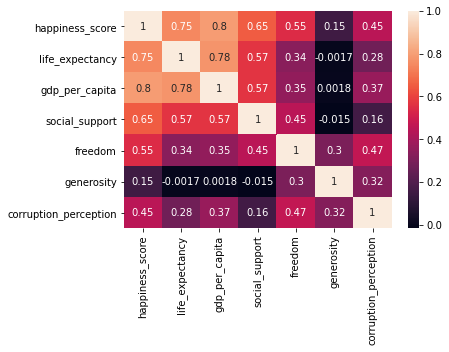

In [8]:
corr_matrix=df[["happiness_score"]+l_factors].corr()

sns.heatmap(corr_matrix, annot = True)

In [30]:
l_features = ['gdp_per_capita', 'life_expectancy', 'social_support', "freedom", "generosity", "corruption_perception"]

In [34]:
y_pred_lin, y_test = compare_algo(fact_train_set, fact_test_set, "happiness_score", l_features, benchmark_test)

,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,113.711,102.219
Polynomial (square) Regression,8499.34,1456.29
Random Forest,97.1666,61.4886


RF params: 
n_estimators: 244 / max_features: auto / max_depth: 7 / min_samples_split 10


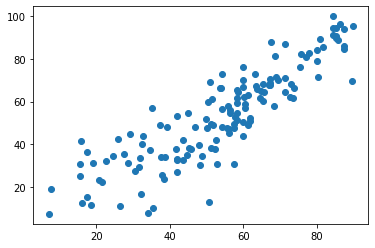

In [35]:
plt.scatter(y_pred_lin, y_test)

**VIF**

**RSE**

------------
------------
<a name="hi"></a>
# 2. Can we predict a country happiness only with his historical ?

<a name="MH1"></a>
## Model 1: using all historical features (from year-1 to year-3)

-------------
<a name="MH2"></a>
## Model 2: using happiness score historical (from year-1 to year-3